In [1]:
import numpy
import scipy.io.wavfile
import matplotlib.pyplot as plt
import os

In [11]:
# Compute MFSC features for CNN training
dir_string = './data/'
file_list = os.listdir(dir_string)
file_list = [file for file in file_list if (file[0] == '0' or file[0] == '1')]

for file in file_list:
	sample_rate, signal = scipy.io.wavfile.read(dir_string + file)
	# create shorter-term frame for signal
	frame_size = 0.025   # number of seconds of each frame
	frame_stride = 0.01  # size of stride between two frames (frame_size - frame_stride = overlap between frames)
	frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
	signal_length = len(signal)
	frame_length = int(round(frame_length))
	frame_step = int(round(frame_step))
	if (signal_length > frame_length):
		num_steps = int(numpy.ceil(float(signal_length - frame_length) / frame_step))
	else:
		num_steps = 1
	num_frames = num_steps + 1
	pad_signal_length = num_steps * frame_step + frame_length # number of zeros to pad at the end of signal
	pad_vector = numpy.zeros((pad_signal_length - signal_length))
	pad_signal = numpy.append(signal, pad_vector)
	indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + \
				numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
			  # indices in emphasized_signal to slice to form frames
	frames = pad_signal[indices.astype(numpy.int32, copy=False)]

	# apply hamming function for FFT
	frames *= numpy.hamming(frame_length)
	# Fourier Transform and Power Spectrum
	NFFT = 512
	mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
	pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

	# apply triangular filter
	nfilt = 40
	low_freq_mel = 0
	high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
	mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale (incl. low&high freq)
	hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
	bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

	fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
	for m in range(1, nfilt + 1):
		f_m_minus = int(bin[m - 1])   # left
		f_m = int(bin[m])			 # center
		f_m_plus = int(bin[m + 1])	# right

		for k in range(f_m_minus, f_m):
			fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
		for k in range(f_m, f_m_plus):
			fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
	filter_banks = numpy.dot(pow_frames, fbank.T)
	filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
	filter_banks = 20 * numpy.log10(filter_banks)  # dB
	#filter_banks = filter_banks.T # 40 nfilt * 63 nframes
	filter_banks1d = filter_banks[:-1] - filter_banks[1:]
	filter_banks2d = filter_banks1d[:-1] - filter_banks1d[1:]

	#filter_banks_concat = numpy.zeros((61*3, 40))
	filter_banks_concat = numpy.zeros((40,61,3))
	filter_banks = filter_banks.T # 40 * 63
	filter_banks1d = filter_banks1d.T # 40 * 62
	filter_banks2d = filter_banks2d.T # 40 * 61
	frame_limit = min(61, filter_banks2d.shape[1])
	for i in range(frame_limit):
		filter_banks_concat[:,:frame_limit,0] = filter_banks[:,:frame_limit]
		filter_banks_concat[:,:frame_limit,1] = filter_banks1d[:,:frame_limit]
		filter_banks_concat[:,:frame_limit,2] = filter_banks2d[:,:frame_limit]
	filter_banks_concat = filter_banks_concat.flatten()
	#print(filter_banks_concat.shape)
	#plt.imshow(filter_banks_concat, cmap='hot', interpolation='nearest')
	#plt.show()
	'''
	frame_limit = min(61, filter_banks2d.shape[0])
	for i in range(frame_limit*3):
		ind_frame = int(i/3)
		ind_deriv = i % 3
		if(ind_deriv == 0):
			filter_banks_concat[i] = filter_banks[ind_frame]
		if(ind_deriv == 1):
			filter_banks_concat[i] = filter_banks1d[ind_frame]
		else:
			filter_banks_concat[i] = filter_banks2d[ind_frame]
	filter_banks_concat = filter_banks_concat.T
	'''
	with open('./cnn_data/' + file[:-4], 'wb') as f:
		numpy.save(f, filter_banks_concat)

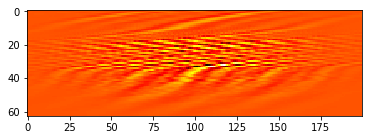

In [3]:
%matplotlib inline
plt.imshow(frames, cmap='hot')

In [40]:
# Compute MFCC features for direct classification
from scipy.fftpack import dct
dir_string = './data/'
file_list = os.listdir(dir_string)
file_list = [file for file in file_list if (file[0] == '0' or file[0] == '1')]

for file in file_list:
	sample_rate, signal = scipy.io.wavfile.read(dir_string + file)
	# create shorter-term frame for signal
	frame_size = 0.025   # number of seconds of each frame
	frame_stride = 0.01  # size of stride between two frames (frame_size - frame_stride = overlap between frames)
	frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
	signal_length = len(signal)
	frame_length = int(round(frame_length))
	frame_step = int(round(frame_step))
	if (signal_length > frame_length):
		num_steps = int(numpy.ceil(float(signal_length - frame_length) / frame_step))
	else:
		num_steps = 1
	num_frames = num_steps + 1
	pad_signal_length = num_steps * frame_step + frame_length # number of zeros to pad at the end of signal
	pad_vector = numpy.zeros((pad_signal_length - signal_length))
	pad_signal = numpy.append(signal, pad_vector)
	indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + \
				numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
			  # indices in emphasized_signal to slice to form frames
	frames = pad_signal[indices.astype(numpy.int32, copy=False)]

	# apply hamming function for FFT
	frames *= numpy.hamming(frame_length)
	# Fourier Transform and Power Spectrum
	NFFT = 512
	mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
	pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

	# apply triangular filter
	nfilt = 40
	low_freq_mel = 0
	high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
	mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale (incl. low&high freq)
	hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
	bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

	fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
	for m in range(1, nfilt + 1):
		f_m_minus = int(bin[m - 1])   # left
		f_m = int(bin[m])			 # center
		f_m_plus = int(bin[m + 1])	# right

		for k in range(f_m_minus, f_m):
			fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
		for k in range(f_m, f_m_plus):
			fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
	filter_banks = numpy.dot(pow_frames, fbank.T)
	filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
	filter_banks = 20 * numpy.log10(filter_banks)  # dB
	#filter_banks = filter_banks.T # 40 nfilt * 63 nframes
	#filter_banks1d = filter_banks[:-1] - filter_banks[1:]
	#filter_banks2d = filter_banks1d[:-1] - filter_banks1d[1:]
    
	num_ceps = 12
	mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13


	cep_lifter = 23
	(nframes, ncoeff) = mfcc.shape
	n = numpy.arange(ncoeff)
	lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
	mfcc *= lift

	# mean normalization
	mfcc -= (numpy.mean(mfcc, axis=0))
    
	mfcc_result = numpy.zeros((63,12))
	dim1 = len(mfcc)
	if (dim1 <= 63):
		mfcc_result[:dim1, :] = mfcc
	else:
		mfcc_result[:,:] = mfcc[:63, :]

	with open('./mfcc_data/' + file[:-4], 'wb') as f:
		numpy.save(f, mfcc_result.T)

In [36]:
from scipy.fftpack import dct
sample_rate, signal = scipy.io.wavfile.read('./data/0_jackson_20.wav')
# create shorter-term frame for signal
frame_size = 0.025   # number of seconds of each frame
frame_stride = 0.01  # size of stride between two frames (frame_size - frame_stride = overlap between frames)
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
signal_length = len(signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
if (signal_length > frame_length):
	num_steps = int(numpy.ceil(float(signal_length - frame_length) / frame_step))
else:
	num_steps = 1
num_frames = num_steps + 1
pad_signal_length = num_steps * frame_step + frame_length # number of zeros to pad at the end of signal
pad_vector = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(signal, pad_vector)
indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + \
			numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
		  # indices in emphasized_signal to slice to form frames
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

# apply hamming function for FFT
frames *= numpy.hamming(frame_length)
# Fourier Transform and Power Spectrum
NFFT = 512
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

# apply triangular filter
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale (incl. low&high freq)
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
	f_m_minus = int(bin[m - 1])   # left
	f_m = int(bin[m])			 # center
	f_m_plus = int(bin[m + 1])	# right

	for k in range(f_m_minus, f_m):
		fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
	for k in range(f_m, f_m_plus):
		fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB
#filter_banks = filter_banks.T # 40 nfilt * 63 nframes
#filter_banks1d = filter_banks[:-1] - filter_banks[1:]
#filter_banks2d = filter_banks1d[:-1] - filter_banks1d[1:]

num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13


cep_lifter = 23
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift

# mean normalization
mfcc -= (numpy.mean(mfcc, axis=0))

mfcc_result = numpy.zeros((63,12))
dim1 = len(mfcc)
if (dim1 <= 63):
    mfcc_result[:dim1, :] = mfcc
else:
    mfcc_result[:,:] = mfcc[:63, :]

(12, 63)


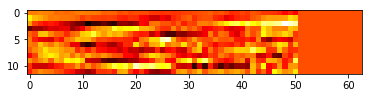

In [41]:
with open('./mfcc_data/1_jackson_0', 'rb') as f:
    mfcc = numpy.load(f)
    
plt.imshow(mfcc, cmap='hot')
print(mfcc.shape)